In [1]:
# import pysindy as ps

import deepSI
from deepSI import System_data
from deepSI.fit_systems import SS_encoder_general
from deepSI.fit_systems.encoders import default_encoder_net, default_state_net, default_output_net
from deepSI.fit_systems.fit_system import My_Simple_DataLoader, print_array_byte_size, Tictoctimer
import torch
from torch import nn

import numpy as np

from sklearn.preprocessing import PolynomialFeatures

from scipy.io import loadmat
import scipy.linalg as lin
import os

from utils import load_data
from SI_SUBNET import SS_encoder_general_eq, h_identity, e_identity, simple_Linear

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import time
from copy import deepcopy
import itertools

from IPython.display import clear_output

c:\Users\Joost\anaconda3\envs\test\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
epochs = 50
nf = 5
batch_size = 256

###UNSCALED NOISY 20dB###

- noisy training data
- 1 step ahead
- identity h and e
- auto norm is on

In [4]:
x_data, u_data, y_data, eq, T, U, set_idx = load_data(set="us_arrow_noisy")
[N_arrow, N_train, N_val, N_test] = set_idx[0]

if T is None:
    T = np.eye(x_data.shape[-1])
if U is None:
    U = np.eye(u_data.shape[-1])

# data organizing
x_arrow, u_arrow = x_data[:N_arrow], u_data[:N_arrow,0]
x_train, u_train = x_data[N_arrow:N_arrow+N_train,:], u_data[N_arrow:N_arrow+N_train,0]
x_val, u_val     = x_data[N_arrow+N_train-N_val:-N_test,:], u_data[N_arrow+N_train-N_val:-N_test,0]
x_test, u_test   = x_data[-N_test:,:], u_data[-N_test:]

# system data
arrow   = System_data(u=u_arrow, y=x_arrow)
train   = System_data(u=u_train, y=x_train)
val     = System_data(u=u_val[:1000], y=x_val[:1000,:])
test    = System_data(u=u_test, y=x_test)

Data loaded from us_arrow_noisy!


In [5]:
train.y.shape, val.y.shape, test.y.shape,arrow.y.shape

((200000, 2), (1000, 2), (50000, 2), (50000, 2))

In [6]:
h_net = h_identity
h_net_kwargs = {}

e_net = e_identity
e_net_kwargs = {}

fit_sys = deepSI.fit_systems.SS_encoder_general(nx=2, na=0, nb=0, na_right=1,\
                                                e_net=e_net, e_net_kwargs=e_net_kwargs,\
                                                h_net=h_net, h_net_kwargs=h_net_kwargs)


In [7]:
nf = dict(nf=nf+1)

fit_sys = deepSI.fit_systems.SS_encoder_general(nx=2, na=0, nb=0, na_right=1,\
                                            e_net=e_net, e_net_kwargs=e_net_kwargs,\
                                            f_net_kwargs=dict(n_nodes_per_layer=64, n_hidden_layers=2),\
                                            h_net=h_net, h_net_kwargs=h_net_kwargs)

fit_sys.fit(train, val, epochs=epochs, batch_size=batch_size, loss_kwargs=nf)

# fit_sys.save_system('SUBNET_n'+nf_str)

test_sim_enc = fit_sys.apply_experiment(test)
print("test")
arrow_sim_enc = fit_sys.apply_experiment(arrow)
print("arrow")

print(test_sim_enc.NRMS(test), arrow_sim_enc.NRMS(arrow))

Initilizing the model and optimizer
Size of the training array =  30.5 MB
N_training_samples = 199995, batch_size = 256, N_batch_updates_per_epoch = 781
Initial Validation sim-NRMS= 1.3100758276161213


  2%|▏         | 1/50 [00:03<02:33,  3.12s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.13770564950927477
Epoch    1, sqrt loss  0.3053, Val sim-NRMS 0.1377, Time Loss: 93.7%, data: 3.0%, val: 3.3%, 249.9 batches/sec


  4%|▍         | 2/50 [00:06<02:26,  3.06s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.11625606307676888
Epoch    2, sqrt loss  0.1343, Val sim-NRMS 0.1163, Time Loss: 93.6%, data: 3.0%, val: 3.3%, 254.5 batches/sec


  6%|▌         | 3/50 [00:09<02:24,  3.07s/it]

Epoch    3, sqrt loss   0.129, Val sim-NRMS 0.1266, Time Loss: 93.6%, data: 3.0%, val: 3.3%, 254.0 batches/sec


  8%|▊         | 4/50 [00:12<02:21,  3.07s/it]

Epoch    4, sqrt loss  0.1262, Val sim-NRMS 0.1181, Time Loss: 93.5%, data: 3.1%, val: 3.3%, 254.2 batches/sec


 10%|█         | 5/50 [00:15<02:25,  3.23s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.1135409753699454
Epoch    5, sqrt loss  0.1254, Val sim-NRMS 0.1135, Time Loss: 93.2%, data: 3.2%, val: 3.5%, 247.2 batches/sec


 12%|█▏        | 6/50 [00:18<02:18,  3.16s/it]

Epoch    6, sqrt loss  0.1247, Val sim-NRMS 0.1189, Time Loss: 93.2%, data: 3.2%, val: 3.4%, 249.0 batches/sec


 14%|█▍        | 7/50 [00:21<02:14,  3.12s/it]

Epoch    7, sqrt loss  0.1247, Val sim-NRMS 0.1143, Time Loss: 93.2%, data: 3.2%, val: 3.5%, 250.1 batches/sec


 16%|█▌        | 8/50 [00:25<02:13,  3.19s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.10935045178738803
Epoch    8, sqrt loss  0.1243, Val sim-NRMS 0.1094, Time Loss: 93.2%, data: 3.3%, val: 3.4%, 248.0 batches/sec


 18%|█▊        | 9/50 [00:28<02:11,  3.20s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.10206932109954528
Epoch    9, sqrt loss  0.1241, Val sim-NRMS 0.1021, Time Loss: 93.2%, data: 3.3%, val: 3.4%, 247.4 batches/sec


 20%|██        | 10/50 [00:31<02:09,  3.24s/it]

Epoch   10, sqrt loss  0.1241, Val sim-NRMS 0.1184, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 246.1 batches/sec


 22%|██▏       | 11/50 [00:34<02:04,  3.19s/it]

Epoch   11, sqrt loss  0.1242, Val sim-NRMS 0.1085, Time Loss: 93.2%, data: 3.3%, val: 3.3%, 246.8 batches/sec


 24%|██▍       | 12/50 [00:38<02:02,  3.23s/it]

Epoch   12, sqrt loss  0.1239, Val sim-NRMS 0.1161, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 245.7 batches/sec


 26%|██▌       | 13/50 [00:41<01:57,  3.16s/it]

Epoch   13, sqrt loss  0.1242, Val sim-NRMS 0.1044, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 246.7 batches/sec


 28%|██▊       | 14/50 [00:44<01:52,  3.12s/it]

Epoch   14, sqrt loss  0.1237, Val sim-NRMS 0.1021, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 247.5 batches/sec


 30%|███       | 15/50 [00:47<01:48,  3.10s/it]

Epoch   15, sqrt loss  0.1239, Val sim-NRMS 0.1068, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 248.0 batches/sec


 32%|███▏      | 16/50 [00:50<01:45,  3.09s/it]

Epoch   16, sqrt loss  0.1237, Val sim-NRMS 0.1052, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 248.5 batches/sec


 34%|███▍      | 17/50 [00:53<01:41,  3.07s/it]

Epoch   17, sqrt loss  0.1236, Val sim-NRMS 0.1035, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 249.0 batches/sec


 36%|███▌      | 18/50 [00:56<01:38,  3.09s/it]

########## New lowest validation loss achieved ########### sim-NRMS = 0.10151525682511228
Epoch   18, sqrt loss  0.1237, Val sim-NRMS 0.1015, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 249.1 batches/sec


 38%|███▊      | 19/50 [00:59<01:38,  3.18s/it]

Epoch   19, sqrt loss  0.1236, Val sim-NRMS 0.1037, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 247.9 batches/sec


 40%|████      | 20/50 [01:03<01:35,  3.19s/it]

Epoch   20, sqrt loss  0.1237, Val sim-NRMS 0.1049, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 247.8 batches/sec


 42%|████▏     | 21/50 [01:06<01:32,  3.18s/it]

Epoch   21, sqrt loss  0.1236, Val sim-NRMS 0.1049, Time Loss: 93.3%, data: 3.3%, val: 3.3%, 247.8 batches/sec


 42%|████▏     | 21/50 [01:07<01:33,  3.23s/it]


Stopping early due to a KeyboardInterrupt
Loaded model with best known validation sim-NRMS of 0.1015 which happened on epoch 18 (epoch_id=18.00)
test
arrow
0.03765664021817936 0.10102510511576926


In [8]:
# save
# fit_sys.save_system('SUBNET_n50_wnl')
# load
# fit_sys = deepSI.load_system(r'result_runs\SUBNET_n50')

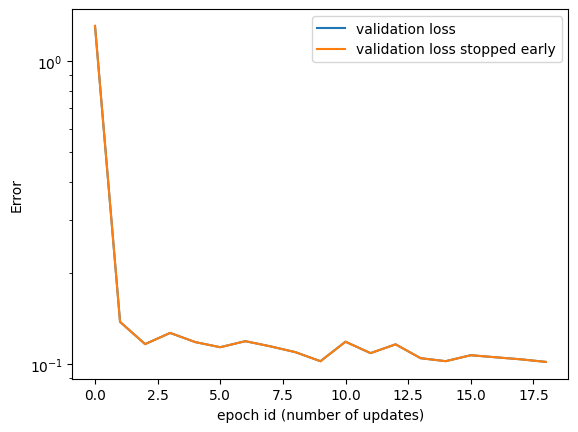

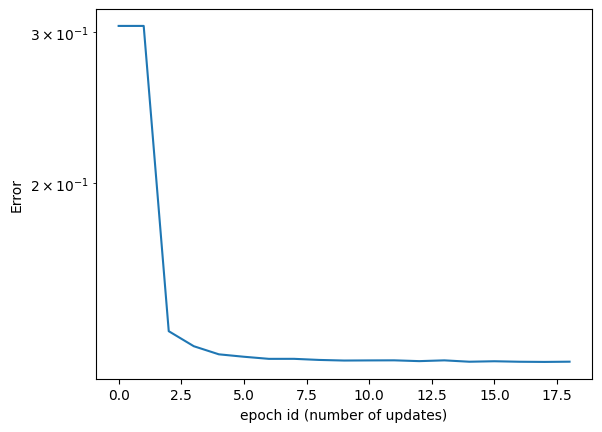

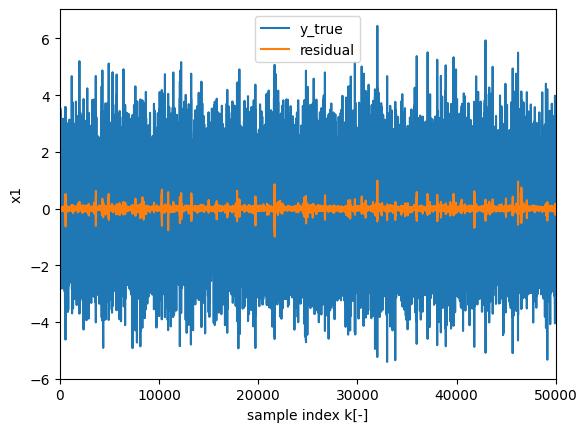

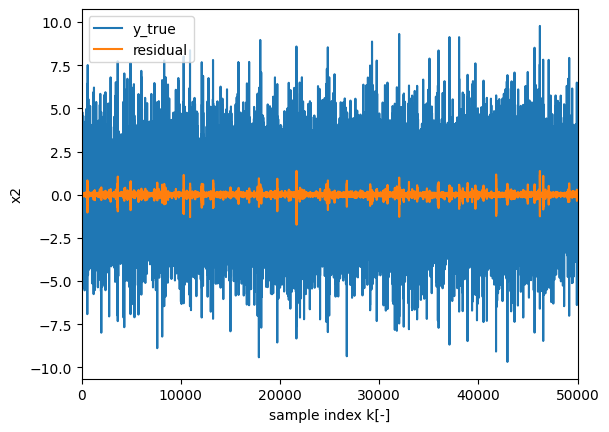

multisin test set simulation SS encoder, NRMS = 0.03765664021817936


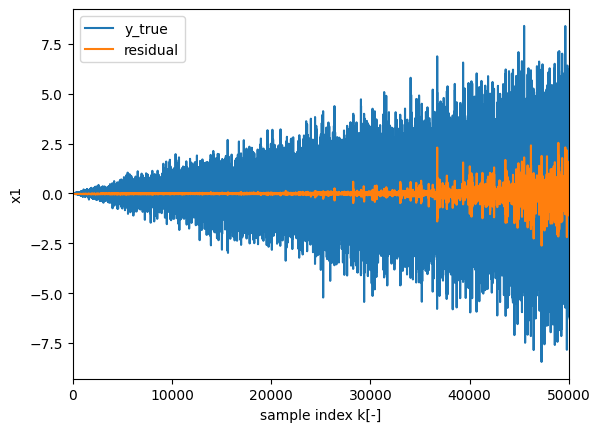

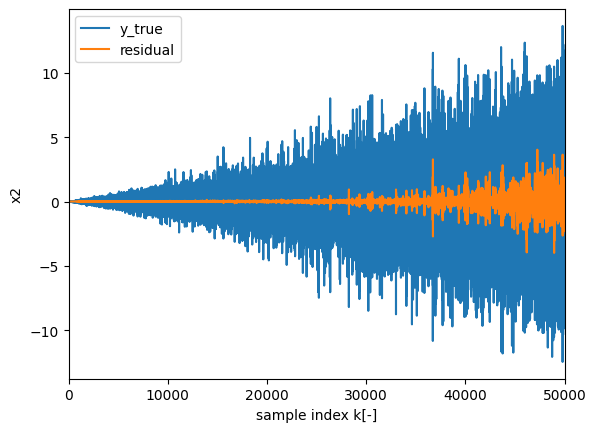

arrow test set simulation SS encoder, NRMS = 0.10102510511576926


In [9]:
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss') 
#or use fit_sys_ss_enc.epoch_id for epochs

plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')

# fit_sys_ss_enc.checkpoint_load_system('_best')
plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_val,label='validation loss stopped early')
plt.legend()
plt.show()

plt.semilogy(fit_sys.epoch_id,fit_sys.Loss_train**0.5,label='train sqrt loss')
plt.xlabel('epoch id (number of updates)')
plt.ylabel('Error')
plt.show()

plt.plot(test.y[:,0])
plt.plot(test.y[:,0]-test_sim_enc.y[:,0])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.xlim([0, test.y[:,0].size])
# plt.ylim([-1,1])
plt.show()

plt.plot(test.y[:,1])
plt.plot(test.y[:,1]-test_sim_enc.y[:,1])
plt.xlabel("sample index k[-]")
plt.ylabel("x2")
plt.legend(["y_true","residual"])
plt.xlim([0, test.y[:,1].size])
# plt.ylim([-1,1])
plt.show()

print(f'multisin test set simulation SS encoder, NRMS = {test_sim_enc.NRMS(test)}')

plt.plot(arrow.y[:,0])
plt.plot(arrow.y[:,0]-arrow_sim_enc.y[:,0])
plt.xlabel("sample index k[-]")
plt.ylabel("x1")
plt.legend(["y_true","residual"])
plt.xlim([0, arrow.y[:,0].size])
# plt.ylim([-1,1])
plt.show()

plt.plot(arrow.y[:,1])
plt.plot(arrow.y[:,1]-arrow_sim_enc.y[:,1])
plt.xlabel("sample index k[-]")
plt.ylabel("x2")
plt.legend(["y_true","residual"])
plt.xlim([0, arrow.y[:,1].size])
# plt.ylim([-1,1])
plt.show()

print(f'arrow test set simulation SS encoder, NRMS = {arrow_sim_enc.NRMS(arrow)}')

In [10]:
test_x1 = test.y[:,0]-test_sim_enc.y[:,0]
test_x2 = test.y[:,1]-test_sim_enc.y[:,1]

test_res = np.c_[test_x1,test_x2]

arrow_x1 = arrow.y[:,0]-arrow_sim_enc.y[:,0]
arrow_x2 = arrow.y[:,1]-arrow_sim_enc.y[:,1]

arrow_res = np.c_[arrow_x1,arrow_x2]

In [11]:
# np.save("subnet_test_res.npy", test_res)
# np.save("subnet_arrow_res.npy", arrow_res)